## Data Ingestion and Transformation

In [5]:
%matplotlib inline

import os
import json
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [6]:
# Load dataset
df = pd.read_csv('dataset-1min.csv')
# Drop duplicates
df = df.drop_duplicates()
df.head(3)

,datetime,temperature,temperature_f,humidity,co2,light,light_status,noise,bluetooth_devices,image_hist_change,door_status,occupancy_count,occupancy_category
0,2017-03-25 09:05:00,22.60,72.68,36.9,781.0,430.000000,light-on,511.000000,1.0,15.242697,closed,0.0,very-low
2,2017-03-25 09:06:00,23.80,74.84,38.9,789.0,437.000000,light-on,491.000000,16.0,15.242697,closed,0.0,very-low
4,2017-03-25 09:07:00,23.85,74.93,38.8,766.0,421.653846,light-on,506.586957,25.0,15.242697,closed,15.0,low


In [7]:
# Determine the shape of the data
print("{} instances with {} features\n".format(*df.shape))

# Determine the frequency of each class
print(df.groupby('occupancy_category')['occupancy_category'].count())

8332 instances with 13 features

occupancy_category
fair         351
high        3342
low          210
very-low    4429
Name: occupancy_category, dtype: int64


In [8]:
# Helper function to encode occupancy_category based on the number of people 
def occupancy(df):
  if df['occupancy_category'] == 'very-low':
    return '1'
  elif df['occupancy_category'] == 'low':
    return '2'
  elif df['occupancy_category'] == 'fair':
    return '3'
  else:
    return '4'

df['occupancy_code'] = df.apply(occupancy, axis=1)
df.head(3)

,datetime,temperature,temperature_f,humidity,co2,light,light_status,noise,bluetooth_devices,image_hist_change,door_status,occupancy_count,occupancy_category,occupancy_code
0,2017-03-25 09:05:00,22.60,72.68,36.9,781.0,430.000000,light-on,511.000000,1.0,15.242697,closed,0.0,very-low,1
2,2017-03-25 09:06:00,23.80,74.84,38.9,789.0,437.000000,light-on,491.000000,16.0,15.242697,closed,0.0,very-low,1
4,2017-03-25 09:07:00,23.85,74.93,38.8,766.0,421.653846,light-on,506.586957,25.0,15.242697,closed,15.0,low,2


In [9]:
# Read the data into a DataFrame
features = [
    'temperature',
    'humidity',
    'co2',
    'light',
    'noise',
    'bluetooth_devices',
    'occupancy_code'
]
classes = [
    'very-low',
    'low',
    'fair',
    'high'
] 

df = df[features]
df.shape

(8332, 7)

In [10]:
# Extract the target from the data
data   = df.ix[:, 0:-1]
target = df.ix[:, -1]

print(data.shape)
print(target.shape)

(8332, 6)
(8332,)


In [11]:
# Split into test and train data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, target)

In [12]:
# Standarize data
from sklearn.preprocessing import StandardScaler
standard_scaler = StandardScaler()
X_train = standard_scaler.fit_transform(X_train)
X_test = standard_scaler.transform(X_test)

## Classification Models Evaluation

In [13]:
from sklearn import metrics
from sklearn.cross_validation import KFold
from yellowbrick.classifier import ClassificationReport, ROCAUC, ClassBalance

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

In [14]:
def fit_and_evaluate(dataset, model, label, **kwargs):
    """
    Because of the Scikit-Learn API, we can create a function to
    do all of the fit and evaluate work on our behalf!
    """
    start  = time.time() # Start the clock! 
    scores = {'precision':[], 'recall':[], 'accuracy':[], 'f1':[]}
    
    for train, test in KFold(data.shape[0], n_folds=12, shuffle=True):
        
        estimator = model(**kwargs)
        estimator.fit(X_train, y_train)
        
        expected  = y_test
        predicted = estimator.predict(X_test)
        
        # Append our scores to the tracker
        scores['precision'].append(metrics.precision_score(expected, predicted, average="weighted"))
        scores['recall'].append(metrics.recall_score(expected, predicted, average="weighted"))
        scores['accuracy'].append(metrics.accuracy_score(expected, predicted))
        scores['f1'].append(metrics.f1_score(expected, predicted, average="weighted"))

    # Report
    print("Build and Validation of {} took {:0.3f} seconds".format(label, time.time()-start))
    print("Validation scores are as follows:\n")
    print(pd.DataFrame(scores).mean())


### Support Vector Classfier

In [15]:
# Perform SVC Classification
svc = SVC()
fit_and_evaluate(df, SVC, "SVM Classifier")

Build and Validation of SVM Classifier took 5.500 seconds
Validation scores are as follows:

accuracy     0.924148
f1           0.898368
precision    0.929549
recall       0.924148
dtype: float64


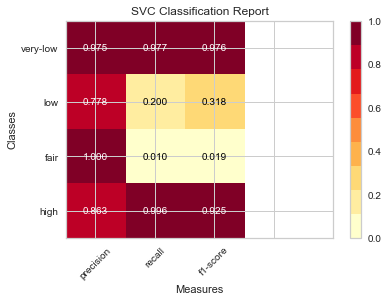

In [16]:
visualizer = ClassificationReport(svc, classes=classes)

visualizer.fit(X_train, y_train)  
visualizer.score(X_test, y_test)  
g = visualizer.poof()

### K Nearest Neighbors Classifier

In [28]:
# Perform kNN Classification
knn = KNeighborsClassifier()
fit_and_evaluate(df, KNeighborsClassifier, "kNN Classifier", n_neighbors=12)

Build and Validation of kNN Classifier took 0.780 seconds
Validation scores are as follows:

accuracy     0.944311
f1           0.937485
precision    0.941137
recall       0.944311
dtype: float64


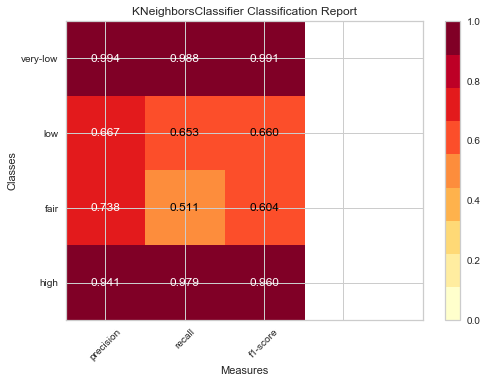

In [29]:
visualizer = ClassificationReport(knn, classes=classes)

visualizer.fit(X_train, y_train)  
visualizer.score(X_test, y_test)  
g = visualizer.poof()

### Random Forest Classfier

In [30]:
# Perform Random Forest Classification
rfc = RandomForestClassifier()
fit_and_evaluate(df, RandomForestClassifier, "Random Forest Classifier")

Build and Validation of Random Forest Classifier took 1.338 seconds
Validation scores are as follows:

accuracy     0.955593
f1           0.953264
precision    0.952740
recall       0.955593
dtype: float64


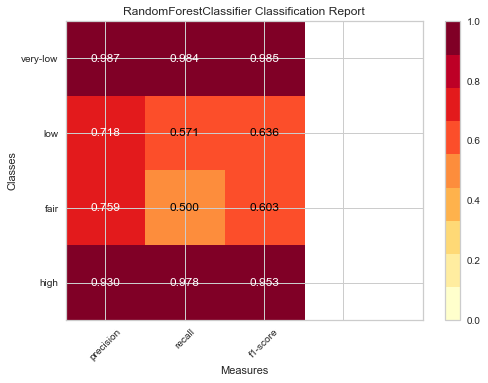

In [31]:
visualizer = ClassificationReport(rfc, classes=classes)

visualizer.fit(X_train, y_train)  
visualizer.score(X_test, y_test)  
g = visualizer.poof()